# 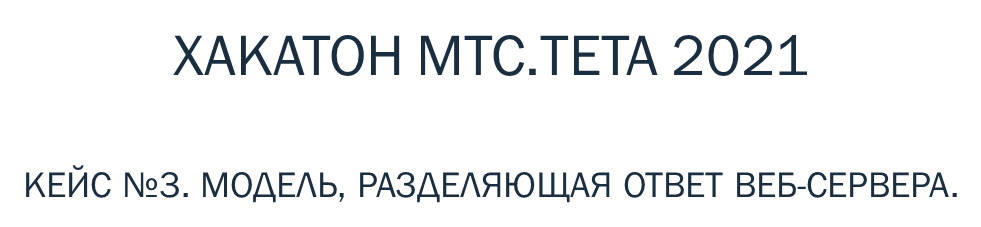

In [ ]:
import math
import numpy as np
import os 
import pandas as pd
from datetime import datetime, timedelta
import matplotlib
import re
import matplotlib.pyplot as plt

In [ ]:
#!pip install -U https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
#!pip install -U pandas-profiling
import pandas_profiling as pp
from pandas_profiling import ProfileReport

### Загрузка и первичная обработка *набора* хостов

In [ ]:
data = pd.read_csv("host.csv",  names=["Request"], squeeze=True)

FileNotFoundError: ignored

In [ ]:
data.drop_duplicates(inplace=True)
data.reset_index(drop = True, inplace = True)
data = data.astype("string")


Загрузка набора хостов с разметкой (разметка проставлена в другом файле)

In [ ]:
subset0_200 = pd.read_csv("subset0-200.csv")

### Создание датасета с *признаками*

In [ ]:
df = pd.DataFrame(data)

In [ ]:
reg_exp = '[.]local([^\w]|$)|sba[.]|[.]onion([^\w]|$)|[.]oz([^\w]|$)|[.]zs([^\w]|$)|[.]i2p([^\w]|$)|m[0-9]|api[0-9]|node[0-9]'
#data.str.contains(reg_exp).value_counts()

In [ ]:
df['len'] = data.str.len() #длина хоста
df['point_ammount'] = data.str.count("\.") #количество точек
df['has_special']=data.str.contains(reg_exp).astype(int) #наличие спец. слов
df['digit_end'] = data.str.rsplit(".", expand=True, n=1)[1].str.contains('\d').astype(int) #наличие цифр в домене верхнего уровня
df['has_www.'] = data.str.contains('www.').astype(int) #наличие www. в запросе

In [ ]:
df['is_Tech'] = subset0_200['request_status']  #вставка колонки с разметкой

In [ ]:
df.head()

### Pandas Profiling Report

In [ ]:
#profile = ProfileReport(df, title='Pandas Profiling Report')
#profile.to_file(output_file="data_profiling_report.html")

### ScLearn. Поиск оптимальной модели (была выбрана линейная регрессия)

In [ ]:
df['is_Tech']=(df['is_Tech']+1)%2 #манипуляции для установки нетехнического запроса на 1, технического на 0
df.rename(columns={"is_Tech": "is_useful",}, inplace = True)

In [ ]:
digit_features = ['len',	'point_ammount',	'has_special',	'digit_end',	'has_www.']
target = ['is_useful']

In [ ]:
from sklearn.linear_model import LogisticRegression  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC 

In [ ]:
from sklearn.model_selection import train_test_split

Валидация

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df[digit_features], df[target], stratify=df[target], test_size=0.25, random_state = 42)

In [ ]:
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [ ]:
reg.fit(X_train,y_train)

In [ ]:
a = np.int8( reg.predict(X_val) > 0.25 ) #установка порога для целевого класса

Подсчёт метрик

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
f1_score(y_val,a),  recall_score(y_val,a)

(0.45794642857142853, 0.6112501489691335)

### Скачивание модели для чат-бота

In [ ]:
import joblib

In [ ]:
joblib.dump(reg, "linear_regression.pkl")

['/content/drive/MyDrive/linear_regression.pkl']

# Работающий чат-бот

In [ ]:
#!pip uninstall telebot
!pip install PyTelegramBotAPI
#!pip install PyTelegramBotAPI==2.2.3

     |████████████████████████████████| 102 kB 34.5 MB/s 
  Created wheel for PyTelegramBotAPI: filename=pyTelegramBotAPI-3.8.2-py3-none-any.whl size=78015 sha256=9d5024055fda86ccdef58fa562ba809cfd6838f5f5c98193f646897a8fedc1af
  Stored in directory: /root/.cache/pip/wheels/05/20/79/0ec340bba3293984eac13cbd480839b754e4edffe1e517f606
Successfully built PyTelegramBotAPI


In [ ]:
clf = joblib.load("linear_regression.pkl")

In [ ]:
class host_predictor(object):
    
    def __init__(self):
      pass

    def predict(self, host):
      length = len(host)
      point_ammount = host.count(".")
      reg_exp = '[.]local([^\w]|$)|sba[.]|[.]onion([^\w]|$)|[.]oz([^\w]|$)|[.]zs([^\w]|$)|[.]i2p([^\w]|$)|m[0-9]|api[0-9]|node[0-9]'
      has_special = int(re.search(reg_exp,host)!=None)
      digit_end = int(re.search('\d', host.rsplit(".")[-1])!=None)
      has_www = int('www.' in host)      

      host = np.array([[length, point_ammount, has_special, digit_end, has_www]])
      status = clf.predict(host)>0.25
      answer = "Запрос " + ("не технический" if status else "технический")
      return answer
      

In [ ]:
predictor = host_predictor()

In [ ]:
predictor.predict('google.com')


'Запрос не технический'

In [ ]:
import telebot

bot = telebot.TeleBot("1993262311:AAHrAmvbFRcoUxwbzacuA7FDVms0Iz5Girk")
@bot.message_handler(commands=['text'])
def send_welcome(message):
  bot.send_message(message.chat.id, message.text)
@bot.message_handler(func=lambda message: True)
def echo_all(message):
  bot.send_message(message.chat.id, predictor.predict(message.text))
bot.polling(none_stop = True)